# Question 7. What Is the Composite Image of the "Ideal" Actor for a Given Character Archetype?

Our analysis reveals that an actor’s traits can significantly influence the roles they are cast in and the archetypes they portray. In this section, we aim to identify the most representative actor profiles for specific archetypes based on historical data. To achieve this, we calculate the average traits of actors associated with each archetype and determine the characteristics most commonly linked to that archetype. We then identify actors whose traits closely align with these averages. The results are the following:

In [1]:
#ignore
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../..')

In [2]:
#ignore
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from src.scripts.load_data import data

In [3]:
#ignore

# Filter only actors with information about weight and height
pd.options.mode.chained_assignment = None

actors_with_stats = data[~(data.actor_height.isna() | data.weight.isna())]
actors_with_stats['actor_date_of_birth'] = pd.to_datetime(actors_with_stats.actor_date_of_birth)
actors_with_stats['movie_release_date'] = pd.to_datetime(actors_with_stats.movie_release_date)

actors_with_stats['years_at_release'] = actors_with_stats['years_in_film']

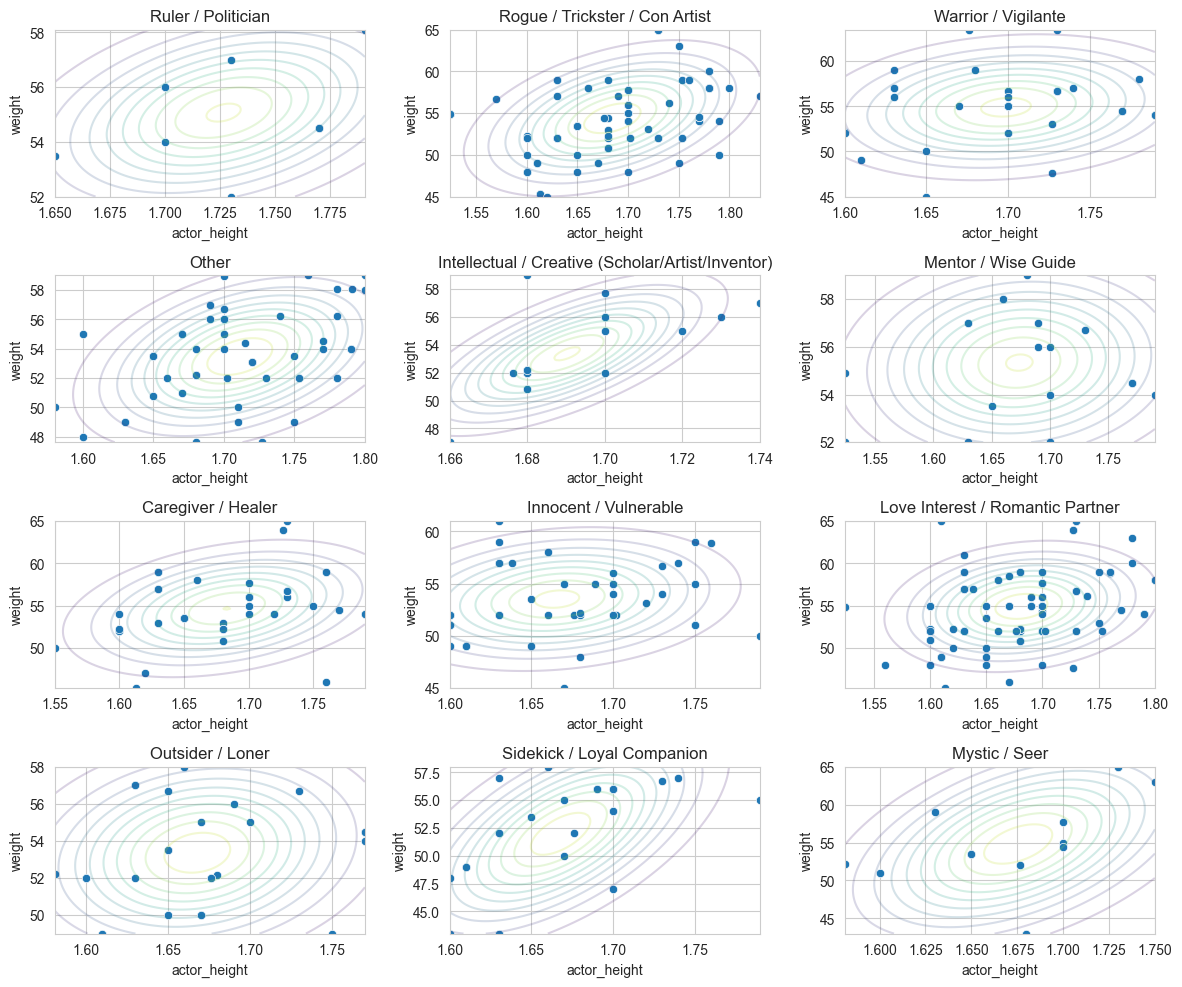

In [4]:
#ignore
from scipy.stats import shapiro
from scipy.stats import multivariate_normal

# Let's check if the distribution of weight/height close to normal for each archetype

def iqr_drop_outliers(df, col):
    height = np.array(df[col])
    q1 = np.percentile(height, 25)
    q3 = np.percentile(height, 75)
    iqr = q3 - q1

    # Define bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return df[(height >= lower_bound) & (height <= upper_bound)]


cur_gender = 'F'
sns.set_style('whitegrid')
plt.figure(figsize=(12,12))
for i, arch in enumerate(actors_with_stats['archetype'].unique()):
    plt.subplot(5,3,i + 1)
    sample = actors_with_stats[actors_with_stats.archetype == arch]
    sample = sample[sample.actor_gender==cur_gender]
    sample = iqr_drop_outliers(sample, 'actor_height')
    sample = iqr_drop_outliers(sample, 'weight')

    plt.title(arch)

    nparray_sample = np.array([sample.actor_height, sample.weight]).T
    mean_estimated = np.mean(nparray_sample, axis=0)
    cov_estimated = np.cov(nparray_sample, rowvar=False)
    x, y = np.linspace(nparray_sample[:, 0].min(), nparray_sample[:, 0].max(), 100), np.linspace(nparray_sample[:, 1].min(), nparray_sample[:, 1].max(), 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    rv = multivariate_normal(mean_estimated, cov_estimated)
    pdf = rv.pdf(pos)
    plt.contour(X, Y, pdf, levels=10, cmap="viridis", alpha=0.2)

    sns.scatterplot(x = sample.actor_height, y = sample.weight)
plt.tight_layout()

In [5]:
#ignore
arch_data = {}

# Plot's seems ok, we'll fit the parameters of the distributions:
for i, arch in enumerate(actors_with_stats['archetype'].unique()):
    most_prob_gender = data[data.archetype == arch].actor_gender.value_counts().keys()[0]
    sample = actors_with_stats[actors_with_stats.actor_gender==most_prob_gender]
    prob_estimated = (sample.archetype == arch).mean()
    sample = sample[sample.archetype == arch]
    sample = iqr_drop_outliers(sample, 'actor_height')
    sample = iqr_drop_outliers(sample, 'years_at_release')
    sample = iqr_drop_outliers(sample, 'weight')

    nparray_sample = np.array([sample.actor_height, sample.weight, sample.years_at_release]).T
    mean_estimated = np.mean(nparray_sample, axis=0)
    cov_estimated = np.cov(nparray_sample, rowvar=False)

    arch_data[arch] = {
        'data' : sample.copy(),
        'mean' : mean_estimated,
        'cov' : cov_estimated,
        'prob' : prob_estimated,
        'gender' : most_prob_gender
    }

In [6]:
#ignore
from scipy.stats import multivariate_normal

# Now we can find actors with highest likelihood
actor_stats_np = np.array([actors_with_stats.actor_height, actors_with_stats.weight, actors_with_stats.years_at_release]).T

arch_to_most_fitting_actors = {}

for i, arch in enumerate(actors_with_stats['archetype'].unique()):
    cur_arch_data = arch_data[arch]
    estimator = multivariate_normal(cur_arch_data['mean'], cur_arch_data['cov'])
    pdf = estimator.pdf(actor_stats_np)
    #arch_to_most_fitting_actors[arch] = actors_with_stats.iloc[pdf.argsort()].groupby('actor_name').first()[:-4:-1] #groupby reorders
    most_fitting_actors = actors_with_stats.iloc[pdf.argsort()][::-1]
    unique_actors = []
    taken_actor_names = []
    for _, row in most_fitting_actors.iterrows():
        if row['actor_name'] not in taken_actor_names:
            taken_actor_names.append(row['actor_name'])
            unique_actors.append(row)
    arch_to_most_fitting_actors[arch] = pd.DataFrame(unique_actors)
        


In [7]:
#ignore
arch_to_most_fitting_actors['Love Interest / Romantic Partner']

,archetype,character_name,movie_name,actor_gender,actor_height,actor_name,actor_date_of_birth,movie_release_date,ethn_name,race,...,nationality,gender,place_of_birth,weight,religion,fb_movie_id,fb_actor_id,years_in_film,actor_bmi,years_at_release
1410,Love Interest / Romantic Partner,Aisha,Body of Lies,F,1.690,Golshifteh Farahani,1983-07-10,2008-10-05,NaN,NaN,...,France,Female,Tehran,55.0,NaN,/m/02q0k7v,/m/0cmy25,25.240246,19.257029,25.240246
49281,Love Interest / Romantic Partner,Maggie Verver,The Golden Bowl,F,1.700,Kate Beckinsale,1973-07-26,2000-05-14,English,European,...,United Kingdom,Female,"Finsbury Park, London",55.0,NaN,/m/0fbjkn,/m/01pk8v,26.800821,19.031142,26.800821
77183,Rogue / Trickster / Con Artist,Sugar,Diamonds,F,1.700,Jenny McCarthy,1972-11-01,1999-09-06,Irish,European,...,United States of America,Female,Evergreen Park,54.0,Catholicism,/m/026wy_s,/m/02t_99,26.844627,18.685121,26.844627
37719,Love Interest / Romantic Partner,Jessie Machalan,Riverworld,F,1.690,Laura Vandervoort,1984-09-22,2010-04-18,NaN,NaN,...,Canada,Female,Toronto,56.0,NaN,/m/0gyl2hg,/m/0k0rvp,25.568789,19.607157,25.568789
30034,Sidekick / Loyal Companion,Grace Santiago,Money Train,F,1.700,Jennifer Lopez,1969-07-24,1995-11-22,Puerto Rican,Latino,...,United States of America,Female,Castle Hill,56.0,Catholicism,/m/0bhh9g,/m/043zg,26.329911,19.377163,26.329911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4521,Warrior / Vigilante,Anton 'The Pro' Protopov,The Big Bang,M,2.100,Robert Maillet,1969-10-26,2010-11-03,Acadian,European,...,Canada,Male,"Sainte-Marie-de-Kent, New Brunswick",158.8,NaN,/m/0g9y7q0,/m/06tg05,41.021218,36.009070,41.021218
43712,Warrior / Vigilante,Kung Fu Giant,Rush Hour 3,M,2.356,Sun Mingming,1983-08-23,2007-07-30,NaN,NaN,...,China,Male,Bayan County,168.0,NaN,/m/06x43v,/m/05sv0t,23.934292,30.266257,23.934292
82473,Sidekick / Loyal Companion,Tut Beemer,MacGruber,M,1.900,Mark Henry,1971-06-12,2010-05-21,African American,African,...,United States of America,Male,Silsbee,189.6,NaN,/m/09rsmds,/m/040vtr,38.940452,52.520776,38.940452
16924,Mystic / Seer,"Dagoth, the Horned God",Conan the Destroyer,M,2.240,André the Giant,1946-05-19,1984-06-29,NaN,NaN,...,France,Male,Grenoble,240.0,NaN,/m/03_8cd,/m/0_f5,38.113621,47.831633,38.113621



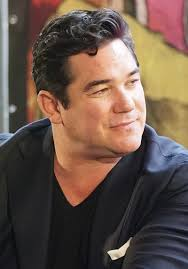
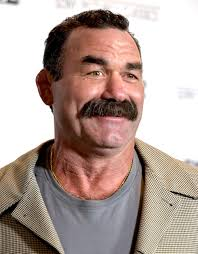
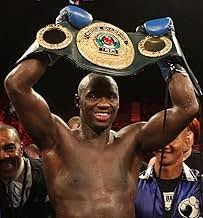
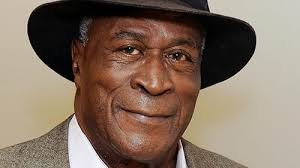
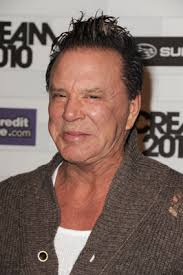
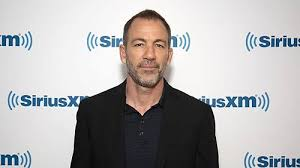
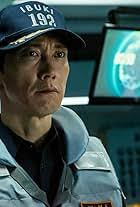
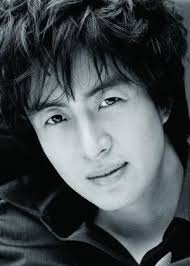
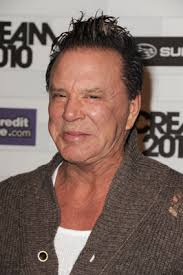
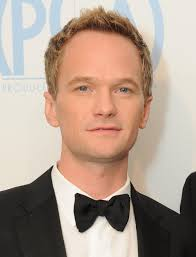
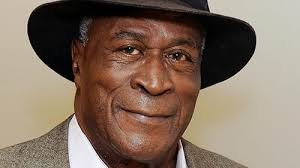
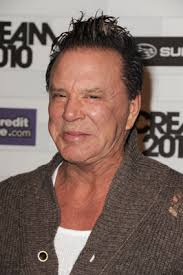
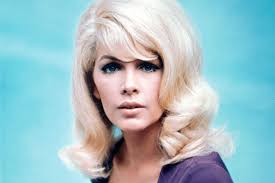
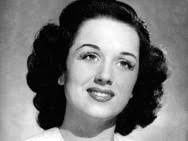
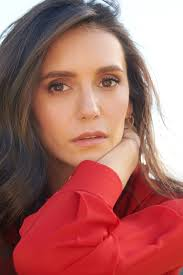
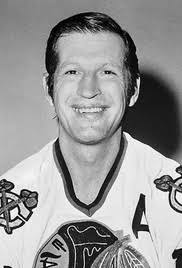
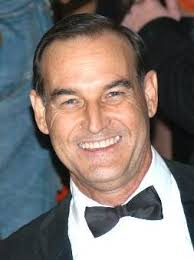
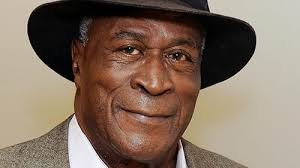
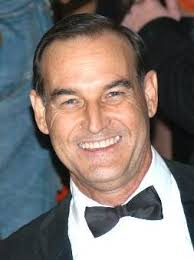
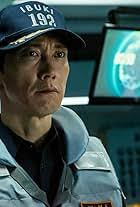
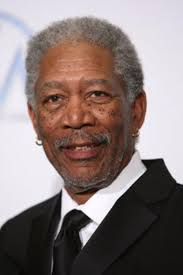
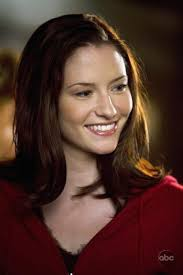
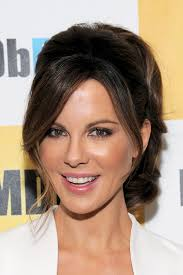
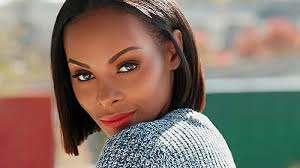
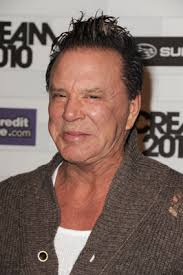
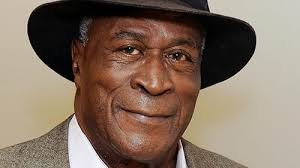
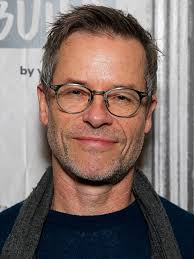
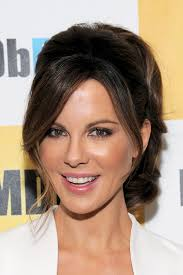
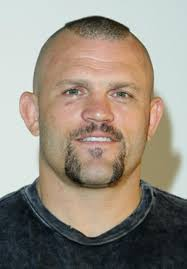
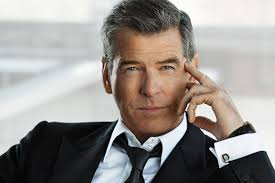
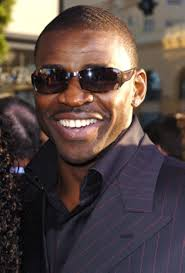

In [9]:
#hidecode
from src.scripts.actor_overview_app import get_actor_overview_html
from IPython.display import display

archetypes = set(actors_with_stats['archetype'].unique()) - set({'Other'})

res_html = get_actor_overview_html(archetypes, arch_data, arch_to_most_fitting_actors)
display(res_html)